# Markdown Infection

In [1]:
import pandas as pd
import sys
import warnings
import numpy as np
import matplotlib.pyplot as plt
import pickle
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import seaborn as sns
import gc
import itertools
import random
import math
from matplotlib.ticker import FormatStrFormatter
import ray
import shapley
sys.path.append('../')



In [21]:
class_risk_params = {
    'prevalence': 5*10**(-4),
    'vax_effectiveness': .715,
    'sensitivity': 0.6,
    'mask_efficacy': 0.8
}


aerosol_params = {
    'inhale_air_rate': 6.8,
    'dose_response_constant': 1440,
    
    'nominal_breathe_virus_emitted_hourly': 3300,# corresponding to 10^8 copies / mL
    'nominal_talk_virus_emitted_hourly' : 27300,
    'nominal_sing_virus_emitted_hourly' : 330000,
    'nominal_heavy_breathe_virus_emitted_hourly': 3300*15,

    'viral_load_distribution': [0.12, 0.22, 0.3, 0.23, 0.103, 0.0236, 0.0034] # over orders of magnitude from 10^5 to 10^11
}

"""
Difference of sets
"""
def Diff(li1, li2):
    li_dif = [i for i in li1 + li2 if i not in li1 or i not in li2]
    return li_dif

"""
Biased coin flipper
"""
def flip(p):
    return 1 if random.random() < p else 0


def simulate_class_single_aerosol(room,vax_infected, unvax_infected, time,alpha,masked_status,class_type,room_height,N,pixels_per_foot, air_exchanges_per_hour):
    room = room.reset_index()
    vax_infect_id = random.sample(list(room[room['seating'] == 'V']['index'].values), vax_infected)
    unvax_infect_id = random.sample(list(room[room['seating'] == 'U']['index'].values), unvax_infected)
    infected = room[room['index'].isin(np.append(vax_infect_id,unvax_infect_id))]
    uninfected = room[ (~room['index'].isin(np.append(vax_infect_id,unvax_infect_id))) & \
                      (room['seating'] != 'E')  ]
    
    if vax_infected == 1:
        source_status = 'V'
    elif unvax_infected == 1:
        source_status = 'U'
    infected_x = infected['x']
    infected_y = infected['y']
    
    
    p_infections = []
    for i,row in uninfected.iterrows():
        
        x = row['x']
        y = row['y']
        v_infect = [x-infected_x,y - infected_y]
        v_vert = [0,10000]
        dot = v_infect[1]*v_vert[1]
        mag1 = 10000
        mag2 = np.sqrt((x-infected_x)**2+(y - infected_y)**2)
        theta =  math.acos(dot/(mag1*mag2))*180/math.pi
        susceptible_status = row['seating']
        
        dist = np.sqrt((infected_x-x)**2+(infected_y-y)**2)
        room_vol = (math.pi*dist*dist*room_height*28.3168).values[0]
        
        unvax_aerosol_risk = (1/air_exchanges_per_hour)*generate_aerosol_risk(room_vol, vax_infected, unvax_infected, time, masked_status, class_type, params = aerosol_params)
        susceptible_aerosol_risk = unvax_aerosol_risk 
        
        if susceptible_status == 'V':
            susceptible_aerosol_risk = susceptible_aerosol_risk * (1-class_risk_params['vax_effectiveness'])
        
        if masked_status == True:
            if susceptible_status == 'U':
                susceptible_aerosol_risk = susceptible_aerosol_risk * class_risk_params['mask_efficacy']
       
        if theta < 90 + alpha:
            p = updated_distance_to_prob(dist,susceptible_status,source_status,masked_status,time,pixels_per_foot)
            p = max(p,susceptible_aerosol_risk)
            p_infections.append(p)
            
        else:
            
            p_infections.append(susceptible_aerosol_risk)
            
    return np.sum(p_infections),unvax_aerosol_risk

def updated_distance_to_prob(d,susceptible_status,source_status,masked_status,time,pixels_per_foot): 
    
    d = d/pixels_per_foot*0.3048
    susceptible_const = 1
    source_const = 1
    masked_const_source = 1
    masked_const_susceptible = 1
    if susceptible_status == 'V':
        susceptible_const = 1 - class_risk_params['vax_effectiveness'] 
    if source_status == 'V':
        source_const = 0.29 
        
    if masked_status == True:
        
        if source_status == 'U':
            masked_const_source = class_risk_params['mask_efficacy']
        if susceptible_status == 'U':
            masked_const_susceptible = class_risk_params['mask_efficacy']
        
        
    prob = 2.4*susceptible_const*masked_const_susceptible *masked_const_source *(1-np.exp(-1 *  source_const * 0.0135 *time * (-0.1819*np.log(d)+0.43276)/d))
    
    prob = float(prob)
    return max(prob,0)

def generate_aerosol_risk(room_vol, vax_infected, unvax_infected, time, masked_status, class_type, params = aerosol_params):
    
    if class_type == 'breathe':
        v = params['nominal_breathe_virus_emitted_hourly'] 
    elif class_type == 'speak':
        v = params['nominal_talk_virus_emitted_hourly'] 
    elif class_type == 'sing':
        v = params['nominal_sing_virus_emitted_hourly'] 
    elif class_type == 'heavy_breathe':
        v = params['nominal_heavy_breathe_virus_emitted_hourly']
    elif class_type == 'no_aerosol':
        return 0
    
    hourly_virus_array = np.array([v/1000, v/100, v/10, v, v*10, v*100, v*1000])
    
    dose_array = hourly_virus_array * params['inhale_air_rate'] / room_vol
    
    if masked_status == True:
        if unvax_infected == 1:
            dose_array = dose_array * class_risk_params['mask_efficacy']
    
    if vax_infected == 1:
        dose_array = dose_array * 0.29 
  
    effective_dose_array = dose_array / params['dose_response_constant']

    unvax_susceptible_risk_array = 1 - np.exp(-effective_dose_array)
    unvax_susceptible_risk = np.dot(unvax_susceptible_risk_array, np.array(params['viral_load_distribution']))
    unvax_susceptible_risk_over_time = 2.4*unvax_susceptible_risk * time

    return unvax_susceptible_risk_over_time #risk for unvax + no mask

In [22]:
def generate_clumpy_plan(N,p,room, clump_size = 3):
    Nvax = round(N*p)
    Nunvax = N-Nvax
    room = room.drop('UnvaxSpot',axis = 1).reset_index()
    grid = room.copy()
    grid['seating'] = 'E'
    
    if Nunvax > 0:
        clump_size = min(clump_size,Nunvax)
        num_clumps = math.floor(Nunvax/clump_size)
        remainder = Nunvax - num_clumps*clump_size
        clump = 0
        while clump < (num_clumps):
            ind1 = np.random.choice(room['index'].values,replace = False)
            grid['seating'].loc[grid['index'] == ind1] = 'U'
            room = room.drop(ind1, axis = 0)
            x_temp = grid['x'].loc[grid['index'] == ind1].values[0]
            y_temp = grid['y'].loc[grid['index'] == ind1].values[0]  
            temp = room.copy()
            temp['dist_infected'] = ((temp['x'] -x_temp) ** 2 + (temp['y'] - y_temp) ** 2) ** 0.5
            temp = temp.sort_values('dist_infected', ascending = True).head(clump_size-1)
            grid['seating'].loc[grid['index'].isin(temp['index'].values)] = 'U'
            room = room.drop(temp['index'].values, axis = 0)
            clump = clump + 1
        remainder_ind = np.random.choice(grid['index'].loc[grid['seating'] == 'E'],remainder,replace = False)
        grid['seating'].loc[grid['index'].isin(remainder_ind)] = 'U'

    vax_ind = np.random.choice(grid['index'].loc[grid['seating'] == 'E'],Nvax,replace = False) 
    grid['seating'].loc[grid['index'].isin(vax_ind)] = 'V'
    
    return grid

def generate_random_plan(N,p,room):
    Nvax = round(N*p)
    Nunvax = N-Nvax
    
    room = room.drop('UnvaxSpot',axis = 1)
    grid = room.copy()
    grid = grid.reset_index()
    temp = list(np.append(np.append(np.repeat('V',Nvax),np.repeat('U',Nunvax)),np.repeat('E',len(grid)-Nvax-Nunvax)))
    random.shuffle(temp)
    grid['seating'] = temp
    return grid


# Load Room Plans

([], [])

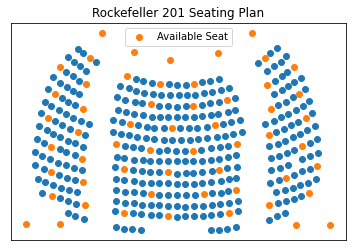

In [23]:
# Big Room
with open("../Data/rk201.pickle" , 'rb') as handle:
    layout = pickle.load(handle)

big_pixels_per_foot = (2074-1575)/20
big_volume = 1684283


x_coord = [i.x for i in layout['Middles']]
y_coord = [i.y for i in layout['Middles']]
room = pd.DataFrame(np.column_stack((x_coord,y_coord)), columns = ['x','y'])
room['UnvaxSpot'] = layout['In Solution']



FA2020room = room.copy()
FA2020room['label'] = FA2020room.index

#label of seats used in 2020
indicies = [282,283,284,285, 286,287,288,289,290,365,238,270,273,110,362,358,227,222,260,104,100,348,352,207,20,250,89,
           93,76,80,189,193,172,163,339,334,321,168,25,2,61,65,51,14,121,138,149,308,312,299,294,144,124,34,40,36]
FA2020room['UnvaxSpot'] = 0
FA2020room['UnvaxSpot'].iloc[indicies] = 1
FA2020room.drop('label', axis =1,inplace = True)
FA2020room['seating'] = 'E'
FA2020room['seating'].loc[FA2020room['UnvaxSpot'] == 1] = 'U'
plt.figure()
plt.scatter(FA2020room[FA2020room['UnvaxSpot'] == 0]['x'],FA2020room[FA2020room['UnvaxSpot'] == 0]['y'])
plt.scatter(FA2020room[FA2020room['UnvaxSpot'] == 1]['x'],FA2020room[FA2020room['UnvaxSpot'] == 1]['y'], label = 'Available Seat')
plt.title('Rockefeller 201 Seating Plan')
FA2020_subset = FA2020room[FA2020room['UnvaxSpot']==1 ].reset_index().drop('index', axis = 1)
big_plan = FA2020_subset.copy()
plt.legend()
plt.xticks([])
plt.yticks([])
#print([big_pixels_per_foot,big_volume,big_plan])

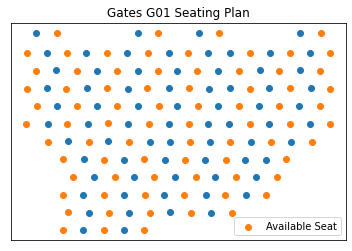

In [24]:
with open("../Data/gtsg01.pickle" , 'rb') as handle:
    layout = pickle.load(handle)

medium_pixels_per_foot = (2834-2082)/20
medium_volume = 1087931

x_coord = [-i.x +3000 for i in layout['Middles']]
y_coord = [-i.y +3000 for i in layout['Middles']]
room = pd.DataFrame(np.column_stack((x_coord,y_coord)), columns = ['x','y'])
room['UnvaxSpot'] = layout['In Solution']
room_subset = room[room['UnvaxSpot'] == 1].reset_index().drop('index',axis = 1)
medium_plan = room_subset.copy()

plt.scatter(room[room['UnvaxSpot'] == 0]['x'],room[room['UnvaxSpot'] == 0]['y'])
plt.scatter(room[room['UnvaxSpot'] == 1]['x'],room[room['UnvaxSpot'] == 1]['y'], label = 'Available Seat')
plt.title('Gates G01 Seating Plan')
plt.xticks([])
plt.yticks([])
plt.legend()

([], [])

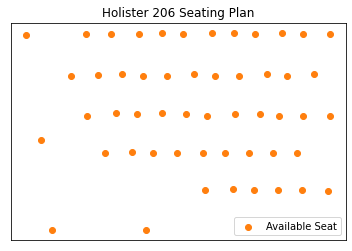

In [25]:
# Small Room
with open("../Data/hls206.pickle" , 'rb') as handle:
    layout = pickle.load(handle)

small_pixels_per_foot = (2014-1260)/15
small_volume = 222004

x_coord = [i.x for i in layout['Middles']]
y_coord = [i.y for i in layout['Middles']]
room = pd.DataFrame(np.column_stack((x_coord,y_coord)), columns = ['x','y'])
room['UnvaxSpot'] = layout['In Solution']


small_plan = room.copy()


plt.figure()
plt.scatter(small_plan[small_plan['UnvaxSpot'] == 0]['x'],small_plan[small_plan['UnvaxSpot'] == 0]['y'])
plt.scatter(small_plan[small_plan['UnvaxSpot'] == 1]['x'],small_plan[small_plan['UnvaxSpot'] == 1]['y'],  label = 'Available Seat')
plt.title('Holister 206 Seating Plan')
plt.legend()
plt.xticks([])
plt.yticks([])

#print([small_pixels_per_foot,small_volume,small_plan])

V    35
U    15
E     6
Name: seating, dtype: int64
V    35
E    27
U    15
Name: seating, dtype: int64
V    35
U    15
E     2
Name: seating, dtype: int64
V    35
U    15
E     6
Name: seating, dtype: int64
V    35
E    27
U    15
Name: seating, dtype: int64
V    35
U    15
E     2
Name: seating, dtype: int64


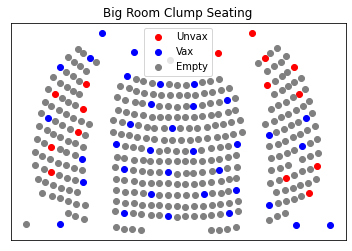

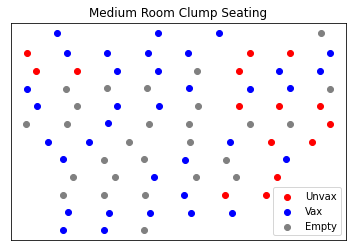

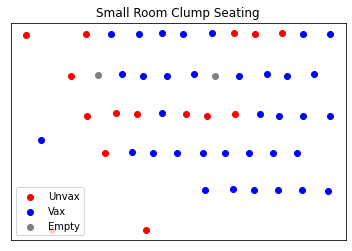

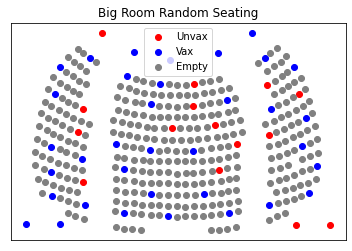

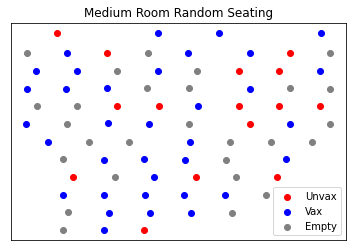

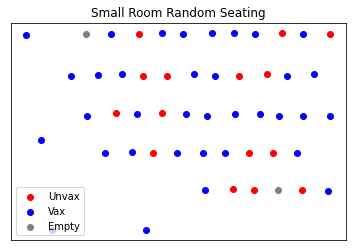

In [26]:
grid = generate_clumpy_plan(50,.7,big_plan,3)
plt.figure()
plt.scatter(grid[grid['seating'] == 'U']['x'],grid[grid['seating'] == 'U']['y'], label = 'Unvax',color = 'red')
plt.scatter(grid[grid['seating'] == 'V']['x'],grid[grid['seating'] == 'V']['y'], label = 'Vax',color = 'blue')
plt.scatter(grid[grid['seating'] == 'E']['x'],grid[grid['seating'] == 'E']['y'], label = 'Empty',color = 'grey')
plt.scatter(FA2020room[FA2020room['UnvaxSpot'] == 0]['x'],FA2020room[FA2020room['UnvaxSpot'] == 0]['y'],color = 'grey')
plt.title('Big Room '+ 'Clump Seating')
plt.legend()
plt.xticks([])
plt.yticks([])
print(grid['seating'].value_counts())

grid = generate_clumpy_plan(50,.7,medium_plan,3)
plt.figure()
plt.scatter(grid[grid['seating'] == 'U']['x'],grid[grid['seating'] == 'U']['y'], label = 'Unvax',color = 'red')
plt.scatter(grid[grid['seating'] == 'V']['x'],grid[grid['seating'] == 'V']['y'], label = 'Vax',color = 'blue')
plt.scatter(grid[grid['seating'] == 'E']['x'],grid[grid['seating'] == 'E']['y'], label = 'Empty',color = 'grey')
plt.title('Medium Room '+ 'Clump Seating')
plt.legend()
plt.xticks([])
plt.yticks([])
print(grid['seating'].value_counts())


grid = generate_clumpy_plan(50,.7,small_plan,3)
plt.figure()
plt.scatter(grid[grid['seating'] == 'U']['x'],grid[grid['seating'] == 'U']['y'], label = 'Unvax',color = 'red')
plt.scatter(grid[grid['seating'] == 'V']['x'],grid[grid['seating'] == 'V']['y'], label = 'Vax',color = 'blue')
plt.scatter(grid[grid['seating'] == 'E']['x'],grid[grid['seating'] == 'E']['y'], label = 'Empty',color = 'grey')
plt.title('Small Room '+ 'Clump Seating')
plt.legend()
plt.xticks([])
plt.yticks([])
print(grid['seating'].value_counts())

grid = generate_random_plan(50,.7,big_plan)
plt.figure()
plt.scatter(grid[grid['seating'] == 'U']['x'],grid[grid['seating'] == 'U']['y'], label = 'Unvax',color = 'red')
plt.scatter(grid[grid['seating'] == 'V']['x'],grid[grid['seating'] == 'V']['y'], label = 'Vax',color = 'blue')
plt.scatter(grid[grid['seating'] == 'E']['x'],grid[grid['seating'] == 'E']['y'], label = 'Empty',color = 'grey')
plt.scatter(FA2020room[FA2020room['UnvaxSpot'] == 0]['x'],FA2020room[FA2020room['UnvaxSpot'] == 0]['y'],color = 'grey')
plt.title('Big Room '+ 'Random Seating')
plt.legend()
plt.xticks([])
plt.yticks([])
print(grid['seating'].value_counts())

grid = generate_random_plan(50,.7,medium_plan)
plt.figure()
plt.scatter(grid[grid['seating'] == 'U']['x'],grid[grid['seating'] == 'U']['y'], label = 'Unvax',color = 'red')
plt.scatter(grid[grid['seating'] == 'V']['x'],grid[grid['seating'] == 'V']['y'], label = 'Vax',color = 'blue')
plt.scatter(grid[grid['seating'] == 'E']['x'],grid[grid['seating'] == 'E']['y'], label = 'Empty',color = 'grey')
plt.title('Medium Room '+ 'Random Seating')
plt.legend()
plt.xticks([])
plt.yticks([])
print(grid['seating'].value_counts())

grid = generate_random_plan(50,.7,small_plan)
plt.figure()
plt.scatter(grid[grid['seating'] == 'U']['x'],grid[grid['seating'] == 'U']['y'], label = 'Unvax',color = 'red')
plt.scatter(grid[grid['seating'] == 'V']['x'],grid[grid['seating'] == 'V']['y'], label = 'Vax',color = 'blue')
plt.scatter(grid[grid['seating'] == 'E']['x'],grid[grid['seating'] == 'E']['y'], label = 'Empty',color = 'grey')
plt.title('Small Room '+ 'Random Seating')
plt.legend()
plt.xticks([])
plt.yticks([])
print(grid['seating'].value_counts())

### Simulator

In [27]:
#General Parameters
seating_function = generate_clumpy_plan
p_range = [0.5,0.6,0.7,0.8,0.9,1.0]

N = 50
angle = 15
time = 1


class_risk_params = {
    'prevalence': 5*10**(-4),
    'vax_effectiveness': .715,
    'sensitivity': 0.6,
    'mask_efficacy': 0.4
}


aerosol_params = {
    'inhale_air_rate': 6.8,
    'dose_response_constant': 1440,
    
    'nominal_breathe_virus_emitted_hourly': 3300,# corresponding to 10^8 copies / mL
    'nominal_talk_virus_emitted_hourly' : 27300,
    'nominal_sing_virus_emitted_hourly' : 330000,
    'nominal_heavy_breathe_virus_emitted_hourly': 3300*15,

    'viral_load_distribution': [0.12, 0.22, 0.3, 0.23, 0.103, 0.0236, 0.0034] # over orders of magnitude from 10^5 to 10^11
}




big_height = 20
medium_height = 15
small_height = 10


args = [
    
    [False,big_plan,big_height,big_pixels_per_foot,'no_aerosol',2,'distanced_outside_nomask'],
    [True,big_plan,big_height,big_pixels_per_foot,'no_aerosol',2,'distanced_outside_unvaxmask'],
    
    [False,big_plan,big_height,big_pixels_per_foot,'breathe',2,'distanced_breathe_nomask_2x'],
    [False,big_plan,big_height,big_pixels_per_foot,'breathe',4,'distanced_breathe_nomask_4x'],
    
    [True,big_plan,big_height,big_pixels_per_foot,'breathe',2,'distanced_breathe_unvaxmask_2x'],
    [True,big_plan,big_height,big_pixels_per_foot,'breathe',4,'distanced_breathe_unvaxmask_4x'],
    
    [False,big_plan,big_height,big_pixels_per_foot,'speak',2,'distanced_speak_nomask_2x'],
    [False,big_plan,big_height,big_pixels_per_foot,'speak',4,'distanced_speak_nomask_4x'],
    
    [True,big_plan,big_height,big_pixels_per_foot,'speak',2,'distanced_speak_unvaxmask_2x'],
    [True,big_plan,big_height,big_pixels_per_foot,'speak',4,'distanced_speak_unvaxmask_4x'],
    
    
    [False,big_plan,big_height,big_pixels_per_foot,'sing',2,'distanced_sing_nomask_2x'],  ###
    [False,big_plan,big_height,big_pixels_per_foot,'sing',4,'distanced_sing_nomask_4x'], ###
    
    [True,big_plan,big_height,big_pixels_per_foot,'sing',2,'distanced_sing_unvaxmask_2x'], ###
    [True,big_plan,big_height,big_pixels_per_foot,'sing',4,'distanced_sing_unvaxmask_4x'], ###
    
    
    #############################################################################################
    
    [False,medium_plan,medium_height,medium_pixels_per_foot,'no_aerosol',2,'moderate_outside_nomask'],
    [True,medium_plan,medium_height,medium_pixels_per_foot,'no_aerosol',2,'moderate_outside_unvaxmask'],
    
    [False,medium_plan,medium_height,medium_pixels_per_foot,'breathe',2,'moderate_breathe_nomask_2x'],
    [False,medium_plan,medium_height,medium_pixels_per_foot,'breathe',4,'moderate_breathe_nomask_4x'],
    
    [True,medium_plan,medium_height,medium_pixels_per_foot,'breathe',2,'moderate_breathe_unvaxmask_2x'],
    [True,medium_plan,medium_height,medium_pixels_per_foot,'breathe',4,'moderate_breathe_unvaxmask_4x'],
    
    [False,medium_plan,medium_height,medium_pixels_per_foot,'speak',2,'moderate_speak_nomask_2x'],
    [False,medium_plan,medium_height,medium_pixels_per_foot,'speak',4,'moderate_speak_nomask_4x'],
    
    [True,medium_plan,medium_height,medium_pixels_per_foot,'speak',2,'moderate_speak_unvaxmask_2x'],
    [True,medium_plan,medium_height,medium_pixels_per_foot,'speak',4,'moderate_speak_unvaxmask_4x'],
    
    
    [False,medium_plan,medium_height,medium_pixels_per_foot,'sing',2,'moderate_sing_nomask_2x'],  ###
    [False,medium_plan,medium_height,medium_pixels_per_foot,'sing',4,'moderate_sing_nomask_4x'], ###
    
    [True,medium_plan,medium_height,medium_pixels_per_foot,'sing',2,'moderate_sing_unvaxmask_2x'], ###
    [True,medium_plan,medium_height,medium_pixels_per_foot,'sing',4,'moderate_sing_unvaxmask_4x'], ###
    
    
    
    #############################################################################################
    
    [False,small_plan,small_height,small_pixels_per_foot,'no_aerosol',2,'dense_outside_nomask'],
    [True,small_plan,small_height,small_pixels_per_foot,'no_aerosol',2,'dense_outside_unvaxmask'],
    
    [False,small_plan,small_height,small_pixels_per_foot,'breathe',2,'dense_breathe_nomask_2x'],
    [False,small_plan,small_height,small_pixels_per_foot,'breathe',4,'dense_breathe_nomask_4x'],
    
    [True,small_plan,small_height,small_pixels_per_foot,'breathe',2,'dense_breathe_unvaxmask_2x'],
    [True,small_plan,small_height,small_pixels_per_foot,'breathe',4,'dense_breathe_unvaxmask_4x'],
    
    [False,small_plan,small_height,small_pixels_per_foot,'speak',2,'dense_speak_nomask_2x'],
    [False,small_plan,small_height,small_pixels_per_foot,'speak',4,'dense_speak_nomask_4x'],
    
    [True,small_plan,small_height,small_pixels_per_foot,'speak',2,'dense_speak_unvaxmask_2x'],
    [True,small_plan,small_height,small_pixels_per_foot,'speak',4,'dense_speak_unvaxmask_4x'],
    
    
    [False,small_plan,small_height,small_pixels_per_foot,'sing',2,'dense_sing_nomask_2x'],  ###
    [False,small_plan,small_height,small_pixels_per_foot,'sing',4,'dense_sing_nomask_4x'], ###
    
    [True,small_plan,small_height,small_pixels_per_foot,'sing',2,'dense_sing_unvaxmask_2x'], ###
    [True,small_plan,small_height,small_pixels_per_foot,'sing',4,'dense_sing_unvaxmask_4x'], ###
    
       ]



In [28]:
@ray.remote
def parallel_wrapper(p):
    trial = 0
    results = []
    results_aerosol = []
    while trial < 500:
        grid = seating_function(N,p,room)
        p_generate = (1-class_risk_params['vax_effectiveness'])*p/(1-class_risk_params['vax_effectiveness']*p)
        ind = flip(p_generate)
        if sum(grid['seating'] == 'V') == 0:
            ind = 0
        elif sum(grid['seating'] == 'U') == 0:
            ind = 1
        
        infect,aerosol = simulate_class_single_aerosol(grid,ind, 1-ind, time,angle,masked_status,class_type,room_height,N,pixels_per_foot,air_exchanges_per_hour)
        results.append(infect)
        results_aerosol.append(aerosol)
        trial = trial + 1
    return [p,np.mean(results),np.std(results), np.mean(results_aerosol)]

In [29]:
import warnings
warnings.filterwarnings("ignore")
final_results = {}
for arg in args:
    print(arg[-1])
    masked_status = arg[0]
    room = arg[1]
    room_height = arg[2]
    pixels_per_foot = arg[3]
    class_type = arg[4]
    air_exchanges_per_hour = arg[5]
    label = arg[6]
    
    
    ray.shutdown()
    ray.init(log_to_driver=False)
    result_ids = []
    for p in p_range:
        result_ids.append(parallel_wrapper.remote(p))    
    results = ray.get(result_ids)  
    ray.shutdown()
    results = pd.DataFrame(results, columns = ['p','mean','std','unvax_aerosol'])
    final_results[label] = results
    gc.collect()

distanced_outside_nomask


2021-08-16 20:48:15,585	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


distanced_outside_unvaxmask


2021-08-16 20:49:40,544	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


distanced_breathe_nomask_2x


2021-08-16 20:51:03,002	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


distanced_breathe_nomask_4x


2021-08-16 20:52:23,913	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


distanced_breathe_unvaxmask_2x


2021-08-16 20:53:50,190	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


distanced_breathe_unvaxmask_4x


2021-08-16 20:55:15,136	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


distanced_speak_nomask_2x


2021-08-16 20:56:38,118	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


distanced_speak_nomask_4x


2021-08-16 20:57:53,906	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


distanced_speak_unvaxmask_2x


2021-08-16 20:59:09,372	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


distanced_speak_unvaxmask_4x


2021-08-16 21:00:25,435	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


distanced_sing_nomask_2x


2021-08-16 21:01:42,417	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


distanced_sing_nomask_4x


2021-08-16 21:03:01,040	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


distanced_sing_unvaxmask_2x


2021-08-16 21:04:15,805	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


distanced_sing_unvaxmask_4x


2021-08-16 21:05:29,643	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


moderate_outside_nomask


2021-08-16 21:06:44,372	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


moderate_outside_unvaxmask


2021-08-16 21:07:57,497	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


moderate_breathe_nomask_2x


2021-08-16 21:09:12,300	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


moderate_breathe_nomask_4x


2021-08-16 21:10:25,314	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


moderate_breathe_unvaxmask_2x


2021-08-16 21:11:37,997	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


moderate_breathe_unvaxmask_4x


2021-08-16 21:12:51,493	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


moderate_speak_nomask_2x


2021-08-16 21:14:04,090	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


moderate_speak_nomask_4x


2021-08-16 21:39:20,408	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


moderate_speak_unvaxmask_2x


2021-08-16 21:58:01,262	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


moderate_speak_unvaxmask_4x


2021-08-16 22:33:24,143	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


moderate_sing_nomask_2x


2021-08-16 23:09:33,920	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


moderate_sing_nomask_4x


2021-08-16 23:10:57,902	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


moderate_sing_unvaxmask_2x


2021-08-16 23:13:12,735	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


moderate_sing_unvaxmask_4x


2021-08-16 23:15:00,199	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


dense_outside_nomask


2021-08-16 23:28:34,775	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


dense_outside_unvaxmask


2021-08-16 23:30:10,497	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


dense_breathe_nomask_2x


2021-08-16 23:31:33,471	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


dense_breathe_nomask_4x


2021-08-16 23:32:51,773	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


dense_breathe_unvaxmask_2x


2021-08-16 23:34:09,771	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


dense_breathe_unvaxmask_4x


2021-08-16 23:35:24,735	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


dense_speak_nomask_2x


2021-08-16 23:36:46,157	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


dense_speak_nomask_4x


2021-08-16 23:38:04,906	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


dense_speak_unvaxmask_2x


2021-08-16 23:39:23,074	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


dense_speak_unvaxmask_4x


2021-08-16 23:40:42,463	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


dense_sing_nomask_2x


2021-08-16 23:42:00,817	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


dense_sing_nomask_4x


2021-08-16 23:43:18,558	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


dense_sing_unvaxmask_2x


2021-08-16 23:44:42,125	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


dense_sing_unvaxmask_4x


2021-08-16 23:45:59,792	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


In [30]:
final_results

{'distanced_outside_nomask':      p      mean       std  unvax_aerosol
 0  0.5  0.009890  0.006030            0.0
 1  0.6  0.008154  0.005403            0.0
 2  0.7  0.006798  0.005049            0.0
 3  0.8  0.004961  0.004175            0.0
 4  0.9  0.003279  0.003228            0.0
 5  1.0  0.001299  0.000546            0.0,
 'distanced_outside_unvaxmask':      p      mean       std  unvax_aerosol
 0  0.5  0.002239  0.000883            0.0
 1  0.6  0.002160  0.000851            0.0
 2  0.7  0.001976  0.000818            0.0
 3  0.8  0.001793  0.000778            0.0
 4  0.9  0.001614  0.000699            0.0
 5  1.0  0.001361  0.000482            0.0,
 'distanced_breathe_nomask_2x':      p      mean       std  unvax_aerosol
 0  0.5  0.009821  0.006020   2.970003e-07
 1  0.6  0.008560  0.005346   2.517114e-07
 2  0.7  0.007056  0.005191   2.413324e-07
 3  0.8  0.005565  0.004675   1.663287e-07
 4  0.9  0.003200  0.003164   1.647556e-07
 5  1.0  0.001391  0.000494   8.742844e-08,
 'di

In [31]:
with open('sim_results/COVID_delta_sims_events_updated_aerosol.pickle', 'wb') as handle:
    pickle.dump(final_results, handle, protocol=pickle.HIGHEST_PROTOCOL)